# Fuel Cell Sizing

## References

[1] PIE-053, Validation et justification des paramètres

[2] Practical application limits of fuel cells and batteries for zero emission vessels, Minnehan and Pratt

[3] Design Considerations for the Electrical Power Supply of Future Civil Aircraft with Active High-Lift Systems, J.-K. Mueller

[4] Fuel Cell Systems Explained, J. Larminie

## Initialization

In this section we initialise the various physical parameters as well as the requirements.
Further information can be found in the references.

In [25]:
import scipy.constants as const 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# INPUT CONDITIONS AND REQUIREMENTS
T        =float(input("Enter operating temperature (K) (ex. 353)")) # Units['K']
P        =float(input("Enter operating pressure [bar] (ex. 1)")) # Units['bar']
P_sizing =float(input("Enter fuel cell sizing power [MW] (ex. 4 MW)"))*10**(6) #Units['W']
P_req    =float(input("Enter the required power for the mission [MW] (ex. 3 MW)"))*10**(6) #Units['W']
wp       =float(input("Enter the weight parameter of the objective function (ex.0.6 if Padim is slighty more important than efficiency)"))
Ncell    =int(input("How many cells does your system have? "))

# INPUT REFERENCE DATA 
T_ref                   = 298.     # Units['K']
P_ref                   = 1.013    # Units['bar']
M_H2                    = 2.02e-3  # Units['kg/mol']
hf_H2Ol                 = -285826. # Units['J/mol'] # se usi questo (liq invece di gassoso) ottieni HHV
hf_H2Og                 = -241826. # Units['J/mol'] # se usi questo ottieni LHV
hf_H2                   = 0        # Units['J/mol'] # H2 enthalpy of formation at standard state
hf_O2                   = 0        # Units['J/mol'] # O2 enthalpy of formation at standard state
sf_H2Ol                 = 69.92    # Units['J/mol'] # se usi questo (liq invece di gassoso) ottieni HHV
sf_H2Og                 = 188.7   # Units['J/mol'] # se usi questo (liq invece di gassoso) ottieni HHV
sf_H2                   = 130.68   # Units['J/mol'] # H2 entropy of formation at standard state
sf_O2                   = 205.14   # Units['J/mol'] # O2 entropy of formation at standard state
specific_energy_H2      = 119.98e6 # Units['J/kg'] # H2 Specific energy
F                       = const.N_A * const.e   # Faraday constant
C                       = 0.06 # Experimental coefficient for the pressure influence on the potential E_r
b                       = 8.314*T/F # Units['V'] # Tafel slope (for activation losses)

# LIMIT CURRENT DENSITY CALCULATION
i_lA =1.45      # Units['A/cm**2']
T_A  =273.15+50 # Units['K']
i_lB =1.57      # Units['A/cm**2']
T_B  =90+273.15 # Units['K']
beta =(i_lA-i_lB)/(1/T_B-1/T_A)
alpha=i_lA+(1/T_A)*(i_lA-i_lB)/(1/T_B-1/T_A)
i_l  =alpha-beta/T  # Units['A/cm**2'] # limiting current density

# EXCHANGE CURRENT DENSITY 
Ea  = 56.9*(10**3)              # Units['J.mol'] # Activation energy
A   = 3.89*(10**(5))            # Units['A/cm**2']
i_0 = A*np.exp(-Ea/(const.R*T)) # Units['A/cm**2'] # Exchange current density

# OHMIC RESISTANCE (to compute ohmic losses)
R_ohm            = 0.245  # Units['ohm*cm**2']

# FUEL CELL REFERENCE DENSITIES # (See : Reference[2]-figures 2.4 & 2.5 ; Reference[3])
specific_power_fc   = 2500          # Units['W/kg']  # rho_fc. This parameter may change according to the manufacturer's specifications.
power_density_fc    = 124.7*10**(3) # Units['W/m^3'] This parameter may change according to the manufacturer's specifications.


Enter operating temperature (K) (ex. 353)380
Enter operating pressure [bar] (ex. 1)2
Enter fuel cell sizing power [MW] (ex. 4 MW)3
Enter the required power for the mission [MW] (ex. 3 MW)2
Enter the weight parameter of the objective function (ex.0.6 if Padim is slighty more important than efficiency)0.3
How many cells does your system have? 100


## Polarization curve

In [26]:
# INITIALIZATION
i                       = 0.001 # Units['A/cm**2']  # to be varied between 0 and i_l for polarization curve
Power_vec               = [] 
eta_vec                 = []
V_act_vec               = [] 
V_ohm_vec               = [] 
V_conc_vec              = [] 
V_pression_vec          = []
V_tot_vec               = [] 
f_vec                   = []
i_vec                   = []

# THERMODYNAMIC EQUATIONS
########## HHV #########
Delta_S                 = sf_H2Ol - (sf_H2+0.5*sf_O2) # Units['J/K'] # Entropy change
Delta_H                 = hf_H2Ol-(hf_H2+0.5*hf_O2)   # Units['J']   # Enthalpy change
########## LHV ###########
Delta_S                 = sf_H2Og - (sf_H2+0.5*sf_O2) # Units['J/K'] # Entropy change
Delta_H                 = hf_H2Og-(hf_H2+0.5*hf_O2)   # Units['J']   # Enthalpy change

Delta_G                 = Delta_H-T_ref*Delta_S       # Units['J']   # Gibbs free energy

E_r                     = - Delta_G/(2.*F)  # Units['V'] # Reversible potential at standard conditions
delta_E_r_T             = Delta_S/(2.*F)*(T-T_ref) # Units['V'] # Potential variation at non standard temperature
delta_E_r_P_ref         = 0
delta_E_r_P             = C * np.log(P/P_ref)+ delta_E_r_P_ref # Units['V'] # Potential variation at non standard pressure
V_rev                   = E_r + delta_E_r_T + delta_E_r_P # Units['V'] # Reversible potential at non standard conditions


while (i < i_l):  
    # VOLTAGE LOSSES (Units['V'])
    v_act          = b*np.arcsinh(i/(2*i_0))  # activation losses
    v_ohm          = i*R_ohm                  # ohmic losses
    v_conc         =8.314*T/(2*F)*(1+1./0.5)*np.log10(i_l/(i_l-i)) # concentration losses
    V_irrev        = v_act+v_ohm+v_conc # total voltage losses
    V              = V_rev-V_irrev  # actual voltage     
    if V<0:
        V=0.0001        
    V_act_vec.append(v_act)
    V_ohm_vec.append(v_ohm)
    V_conc_vec.append(v_conc)
    V_tot_vec.append(V)
   
    # POWER (Units['W/cm^2'])
    P_adim = V*i  
    Power_vec.append(P_adim)

    # EFFICIENCY
    #eta = Delta_G/Delta_H*V/V_rev
    eta = -V*2*F/Delta_H
    eta_vec.append(eta) 
  
    # Objective function for trade off between efficiency and power
    f = wp*P_adim+(1-wp)*eta
    f_vec.append(f)
   
    # repeat for next current
    i_vec.append(i)
    i+= 0.002  

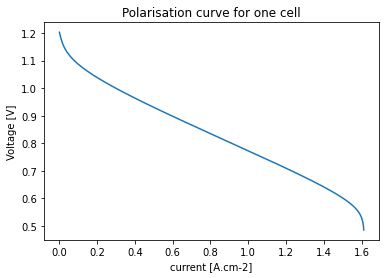

In [27]:
# PLOT POLARIZATION CURVE  
x = np.arange(0.001, i_l, 0.002)    
plt.plot(x, V_tot_vec)
plt.ylabel('Voltage [V]')
plt.xlabel('current [A.cm-2]')
plt.title('Polarisation curve for one cell')
plt.show()  

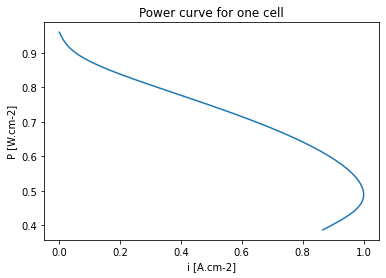

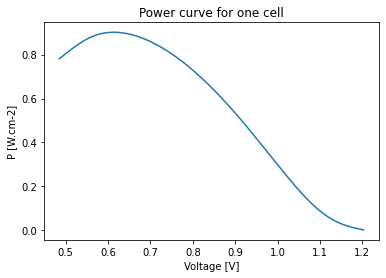

In [22]:
# PLOT POWER CURVES
plt.plot( Power_vec/max(Power_vec),eta_vec)
plt.ylabel('P [W.cm-2]')
plt.xlabel('i [A.cm-2]')
plt.title('Power curve for one cell')
plt.show() 

plt.plot(V_tot_vec, Power_vec)
plt.ylabel('P [W.cm-2]')
plt.xlabel('Voltage [V]')
plt.title('Power curve for one cell')
plt.show() 

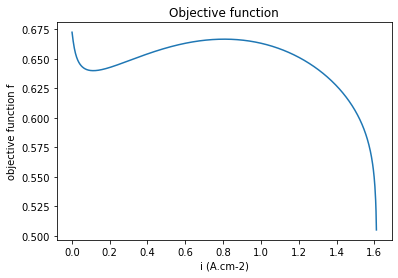

In [28]:
# PLOT OBJECTIVE FUNCTION
plt.plot(x, f_vec)
plt.ylabel('objective function f')
plt.xlabel('i (A.cm-2)')
plt.title('Objective function')
plt.show() 

## Sizing

In [37]:
### OPTIMUM POINT correspond to the maximisation of the objective function f ###
f_max = max(f_vec)

# intensity density corresponding to f_max
f_i       = interp1d(f_vec, i_vec)
i_optimum = f_i(f_max)
print(np.shape(f_vec),np.shape(i_vec))
# voltage corresponding to i_optimum
V_i       = interp1d(i_vec, V_tot_vec)
V_optimum = V_i(i_optimum)

# Arguments eta and power at optimum point
#eta_optimum            = Delta_G/Delta_H*V_optimum/V_rev
eta_optimum = -V_optimum*2*F/Delta_H
P_optimum_adim         = V_optimum*i_optimum

### FUEL CELL SIZING ###
Acell                  = P_sizing/(Ncell*V_optimum*i_optimum) # Units['cm2']
m_FC                   = max(Power_vec)/P_optimum_adim * P_sizing/specific_power_fc # Units['kg']
volume_FC              = max(Power_vec)/P_optimum_adim * P_sizing/power_density_fc  # Units['m^3']

print('Optimal current for one cell (A/cm^2): ', i_optimum)
print('Optimal power for one cell (W/cm^2): ', P_optimum_adim)
print('Optimal efficiency: ', eta_optimum)
print('----------------------------------------------')
print('Total area (m^2): ', Acell*Ncell/10000)
print('Fuel cell weight (kg): ', m_FC)
print('Fuel cell volume (m^3): ', volume_FC)

(771,) (771,)
Optimal current for one cell (A/cm^2):  1.0310000000000008
Optimal power for one cell (W/cm^2):  0.7189357410387618
Optimal efficiency:  0.5564417512100197
----------------------------------------------
Total area (m^2):  556.3779586504572
Fuel cell weight (kg):  1782.9626603146787
Fuel cell volume (m^3):  35.7450413054266


## Performance for a given power

In [32]:
### PERFORMANCE for a given power ###

# Initialisation
P_vec_univ=[]
V_vec_univ=[]
Pmax = max(Power_vec) 
index_Pmax= Power_vec.index(Pmax)
i=0
while i<=index_Pmax:
    P_vec_univ.append(Power_vec[i])
    i+=1
    V_vec_univ.append(V_tot_vec[i])
     
# Voltage, current, efficiency, fuel flow calculation
P_adim      = P_req/(Ncell*Acell)           
V_req_cell  = np.interp(P_adim,P_vec_univ,V_vec_univ)   
I_req_adim  = P_adim/V_req_cell
I_req_cell  = I_req_adim*Acell         
V_req_stack = V_req_cell*Ncell                       #cells in parallel
I_req_stack = I_req_cell                             #cells in parallel
#eta_req     = Delta_G/Delta_H*V_req_cell/V_rev
eta_req     = -V_req_cell*2*F/Delta_H
fuel_flow   = M_H2 * P_req/(2*F*V_req_cell)          # Units['kg/s']   # From reference[4] (eq. A2.8)
air_flow    = 3.57*(10**(-7))*2*P_req/V_req_cell     # Units['kg/s']   # From reference[4] (eq. A2.4)
thermal_power= fuel_flow*specific_energy_H2


### OUTPUT RESULTS ###
titles        =['Parameters','Asked operating point']
parameters    =['i_adim (A/cm^2)','i_stack (A)','V_stack (V)', 'V_cell (V)', 'P_adim_stack (W/cm^2)','P_stack (W)','efficiency']
param_req     =[I_req_adim,I_req_stack, V_req_stack, V_req_cell, P_adim,P_adim*Acell*Ncell,eta_req]

data          = [titles]+list(zip(parameters,param_req))
for i,d in enumerate(data):
    line='|'.join(str(x).ljust(33) for x in d)
    print(line)
    if i==0:
        print('-'*len(line))
print('-'*len(line))

print('Total active surface (m^2): ', Ncell*Acell/10000)
print('Fuel cell weight (kg): ', m_FC)
print('Fuel cell volume (m^3): ', volume_FC)
print('H2 flow (kg/s): ', fuel_flow)
print('air flow (kg/s): ', air_flow)

# See reference [3] for mass comparison (Active high-lift systems requiring 2MW leads to a 1000kg fuel cell).

Parameters                       |Asked operating point            
-------------------------------------------------------------------
i_adim (A/cm^2)                  |1.031927327666682                
i_stack (A)                      |57414.162004281                  
V_stack (V)                      |69.66922202403208                
V_cell (V)                       |0.6966922202403208               
P_adim_stack (W/cm^2)            |0.7189357410387618               
P_stack (W)                      |4000000.0                        
efficiency                       |0.5559417122858056               
-------------------------------------------------------------------
Total active surface (m^2):  556.3779586504572
Fuel cell weight (kg):  1782.9626603146787
Fuel cell volume (m^3):  35.7450413054266
H2 flow (kg/s):  0.06010064156716971
air flow (kg/s):  4.099371167105663


In [36]:
import numpy as np
np.shape(V_tot_vec)

(771,)